In [1]:
import wandb
import torch
from torch.nn import MSELoss
from traj_dataset import TrajDataset
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
import PIL
from model import SimpleViT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda:0


In [8]:
api = wandb.Api()
# get run
run_id = "gqtd71or"
run = api.run("/depren/thesis_official_runs/runs/" + run_id)

# load model
conf = run.config

model = SimpleViT(dim=conf['model_dimension'],
                  device=device,
                  mlp_dim=conf['mlp_dimension'],
                  image_size=(conf['image_size'], conf['image_size']),
                  image_patch_size=(conf['patch_size'], conf['patch_size']),
                  frame_patch_size=conf['patch_depth'],
                  frames=conf['n_prev'],
                  depth=conf['model_depth'],
                  heads=conf['heads'],
                  )
print(model.device)
model.load_state_dict(torch.load(conf['save_name'],map_location=device))
print(model.device)




cuda:0
cuda:0


In [61]:
folders = [f"bookstore/video{k}/" for k in range(1)]
folders += [f"coupa/video{k}/" for k in range(1)]
folders += [f"deathCircle/video{k}/" for k in range(1)]
folders += [f"gates/video{k}/" for k in range(1)]
folders += [f"hyang/video{k}/" for k in range(1)]
folders += [f"little/video{k}/" for k in range(1)]
folders += [f"nexus/video{k}/" for k in [k for k in range(1) if k in [5,6]]]
folders += [f"quad/video{k}/" for k in range(1)]



In [11]:

data_config = run.config['dataset']
folders = TrajDataset.conf_to_folders(data_config)
size = f"{conf['image_size']}_{conf['image_size']}_{conf['block_size']}"
data_folders = ["/waldo/walban/student_datasets/arfranck/SDD/scenes/" + folder + size for folder in folders]


props = [conf['train_prop'], conf['val_prop'], conf['test_prop']]
n_prev = conf['n_prev']
n_next = conf['n_next']
img_step = conf['img_step']
train_data = TrajDataset(data_folders, n_prev=n_prev, n_next=n_next, img_step=img_step,limit=20, prop=props, part=0,path=True)
val_data = TrajDataset(data_folders, n_prev=n_prev, n_next=n_next, img_step=img_step,limit=20, prop=props, part=1,path=True)
test_data = TrajDataset(data_folders, n_prev=n_prev, n_next=n_next, img_step=img_step,limit=20, prop=props, part=2,path=True)

1154
opening track 157 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 914 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 559 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 603 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 617 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 445 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 92 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 949 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 490 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video1/64_64_4
opening track 1129 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/

In [12]:
batch_size=conf['batch_size']
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
counter = 0

1
Test Batch 0
0.00017074044444598258
0.0010464792139828205
8


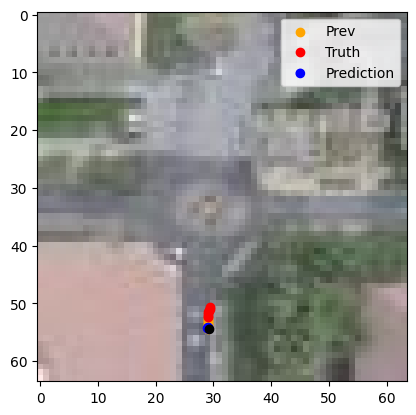

Test Batch 1
0.0003246430424042046
0.0001305803598370403
8


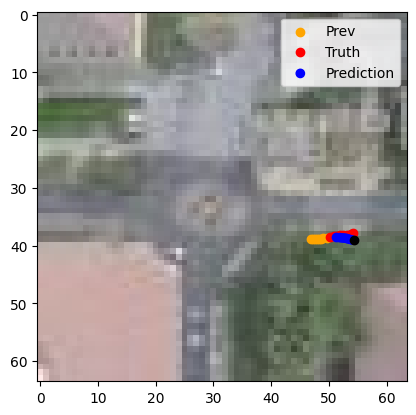

Test Batch 2
0.00015397350944112986
6.260542431846261e-05
8


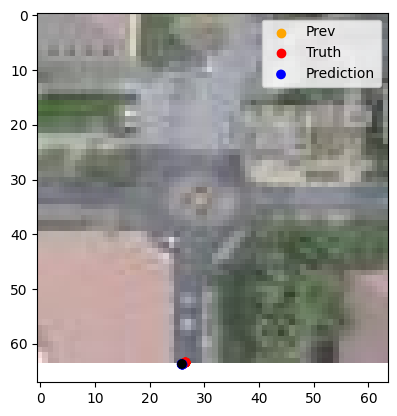

Test Batch 3
0.0002334074815735221
0.00010879756882786751
8


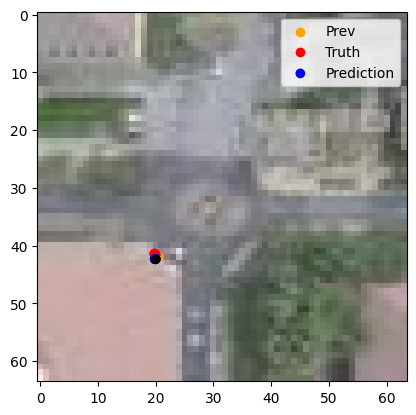

Test Batch 4
0.00017240698798559606
4.157440343988128e-05
8


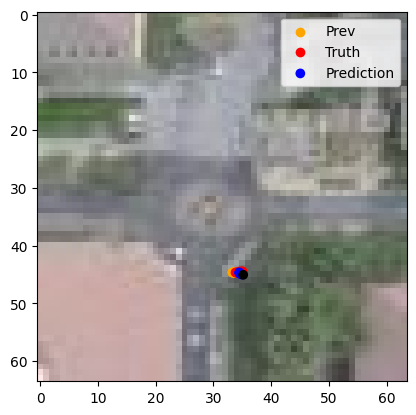

Test Batch 5
0.00010125464177690446
0.00026857241755351424
8


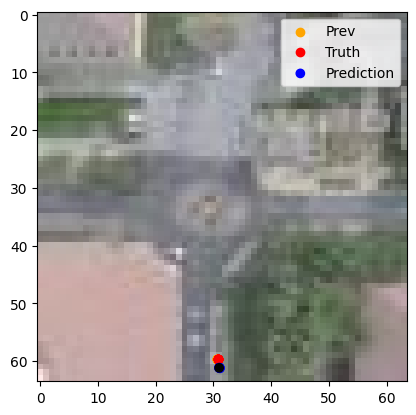

Test Batch 6
0.00013395087444223464
9.332645277027041e-05
8


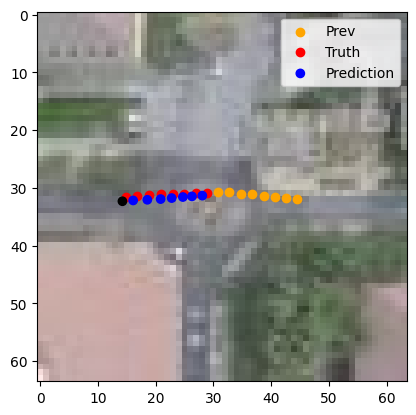

Test Batch 7
0.00029978243401274085
0.0001614290231373161
8


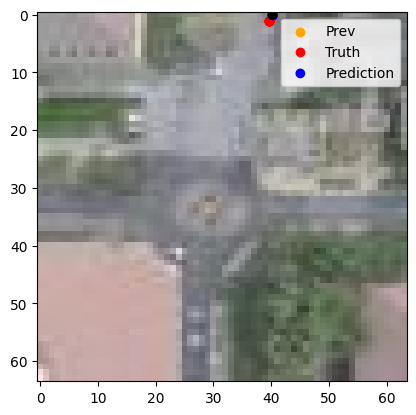

Test Batch 8
0.00021605002984870225
2.8646183636737987e-05
8


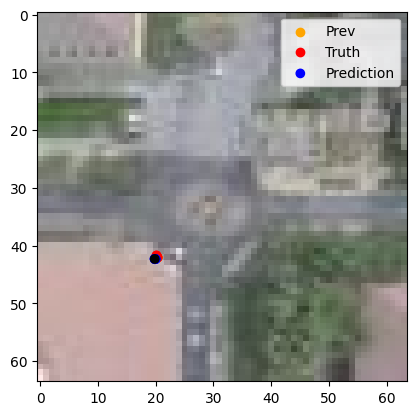

Test Batch 9
0.0001544230035506189
7.493001612601802e-05
8


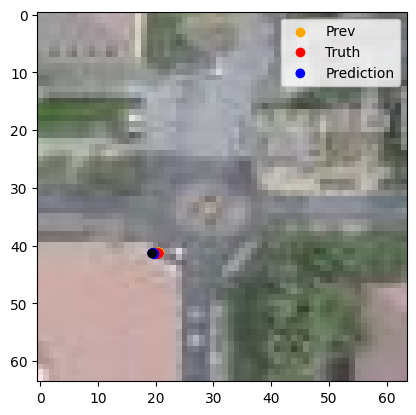

Test Batch 10
0.00046716444194316864
8.591845107730478e-05
8


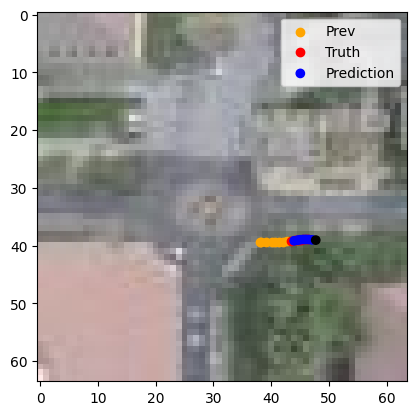

Test Batch 11
0.00015215839084703475
1.6274178051389754e-05
8


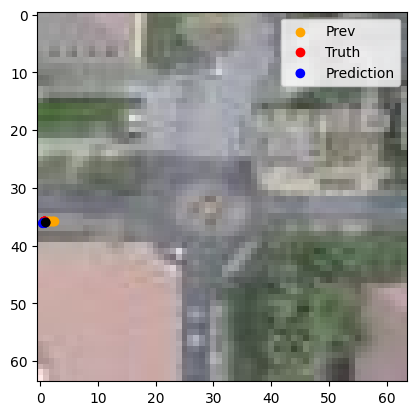

Test Batch 12
0.00014679422019980848
0.00014477281365543604
8


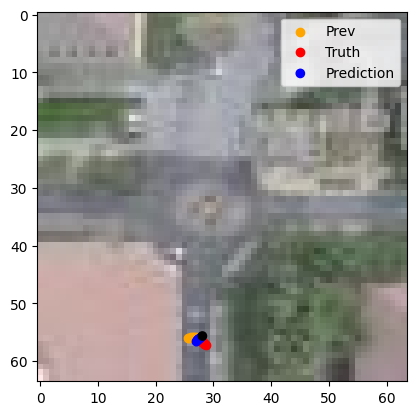

Test Batch 13
0.00014904994168318808
6.244680844247341e-05
8


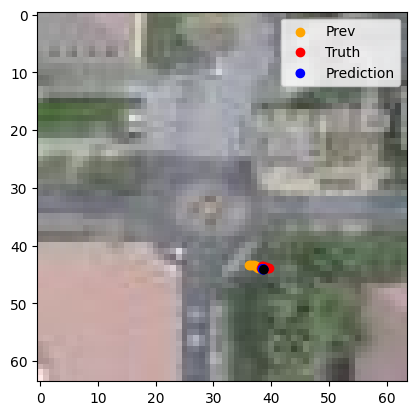

Test Batch 14
0.00011102452845079824
3.369408659636974e-05
8


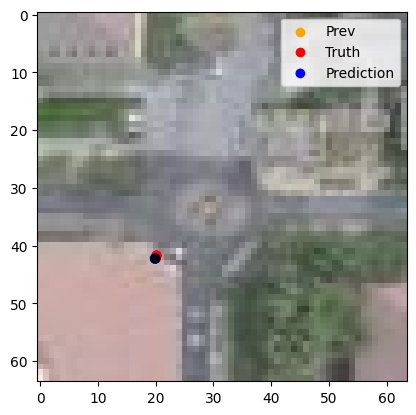

Test Batch 15
0.0001770839880919084
0.00013552495511248708
8


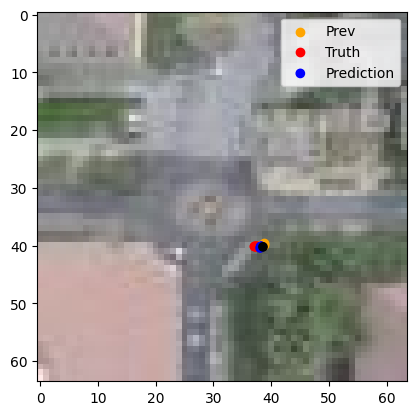

Test Batch 16
0.00015649084525648504
9.831783245317638e-06
8


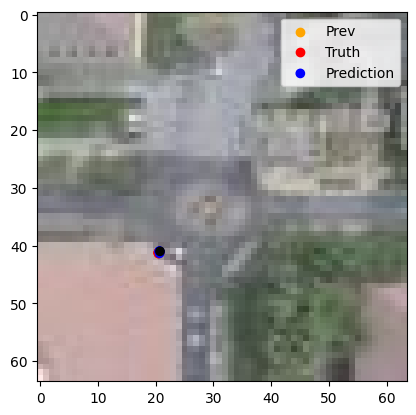

Test Batch 17
0.00013673256034962833
8.635652920929715e-05
8


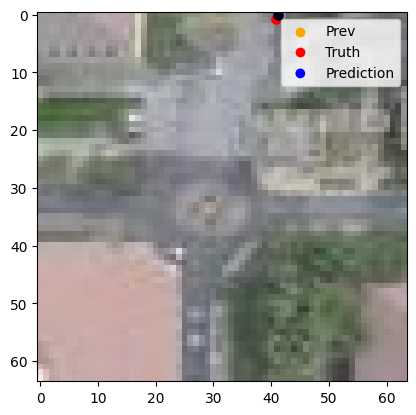

Test Batch 18
0.00030996595160104334
0.0030994685366749763
8


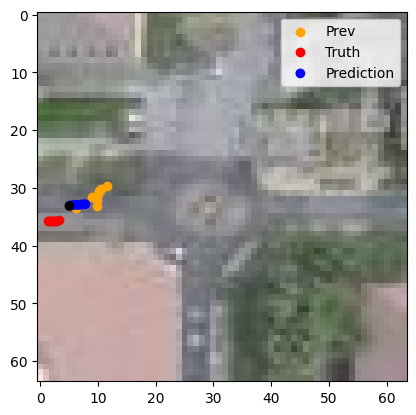

Test Batch 19
0.0002434284397168085
0.0003944344352930784
8


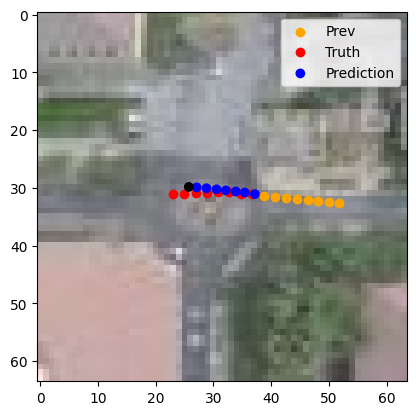

Test Batch 20
0.00019985811377409846
4.2393076000735164e-05
8


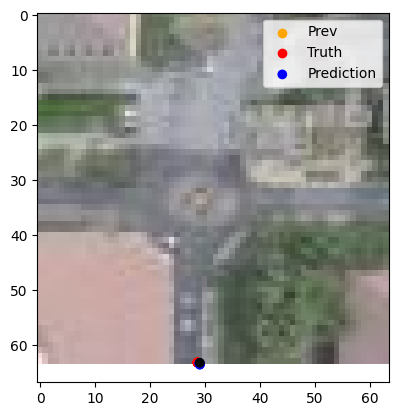

Test Batch 21
0.0003864929894916713
4.5443433918990195e-05
8


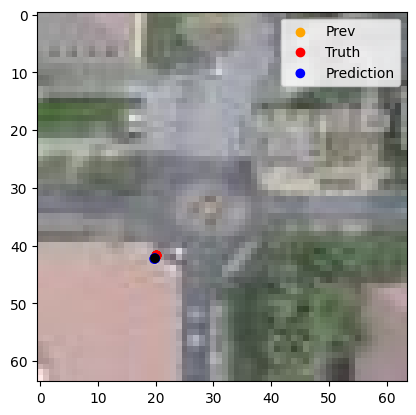

Test Batch 22
0.00012062815949320793
3.373767867742572e-06
8


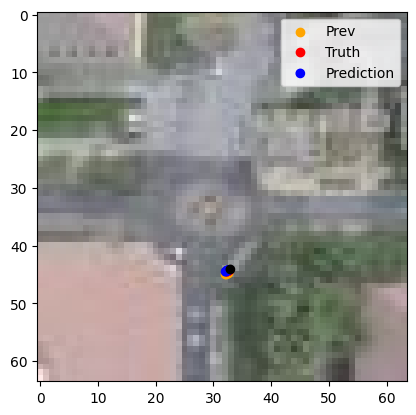

Test Batch 23
0.0005572561640292406
4.668935798690654e-05
8


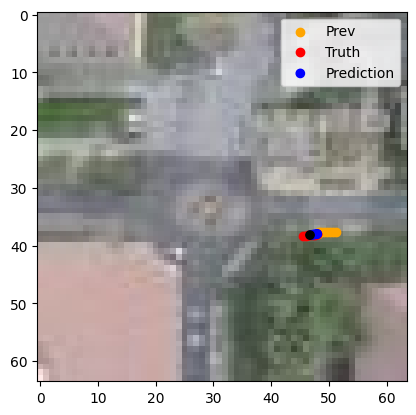

Test Batch 24
9.704397962195799e-05
2.1096708223922178e-05
8


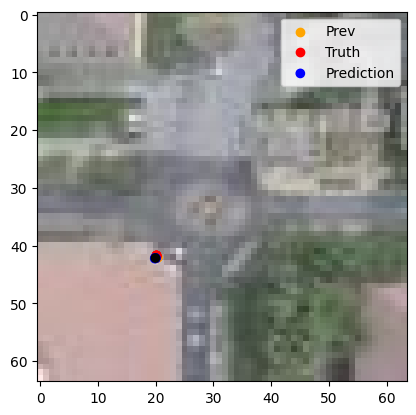

Test Batch 25
0.00015803045243956149
0.000165075296536088
8


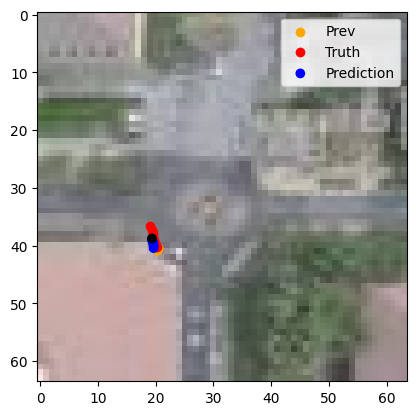

Test Batch 26
0.00031663005938753486
0.00010859432222787291
8


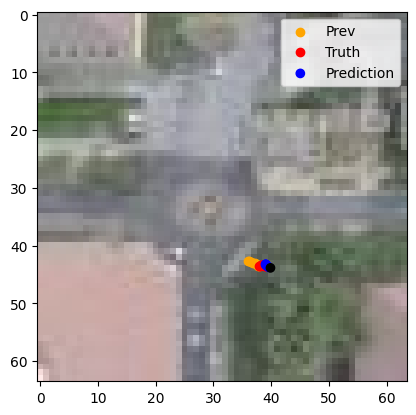

Test Batch 27
0.00026799034094437957
0.0004539893998298794
8


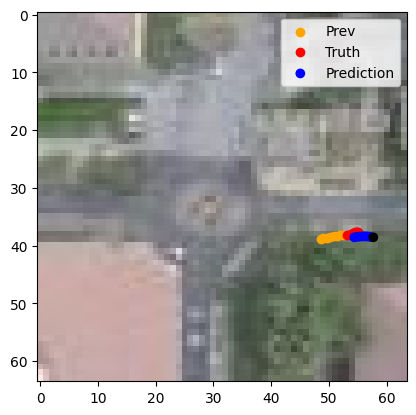

Test Batch 28
0.0001733475219225511
7.878418546169996e-05
8


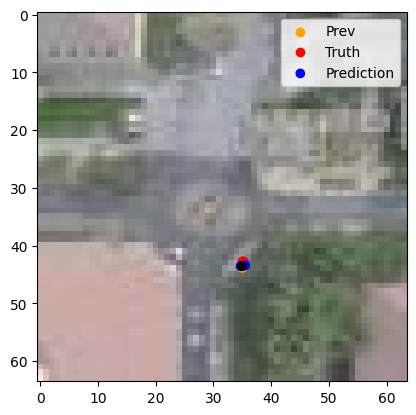

Test Batch 29
0.00017206542543135583
7.601716788485646e-05
8


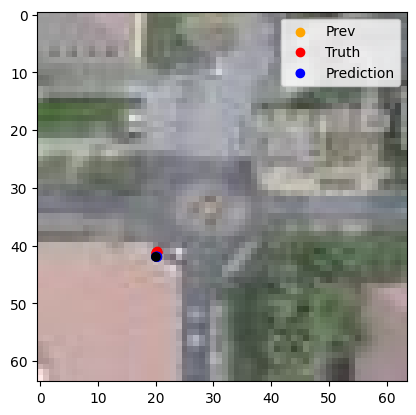

Test Batch 30
0.00010117098281625658
0.0003252473834436387
8


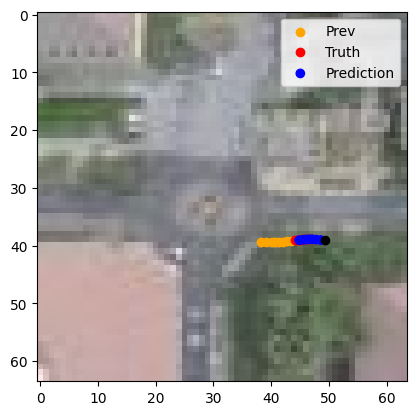

Test Batch 31
0.00019074379815720022
0.00010250997002003714
8


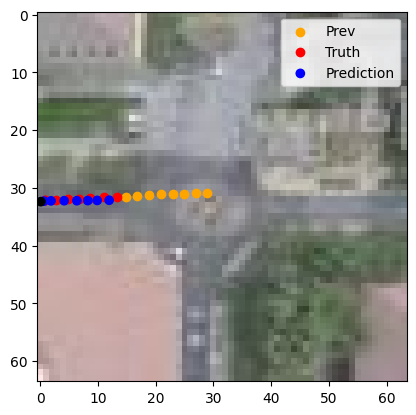

Test Batch 32
0.0003729478339664638
0.00017525644216220826
8


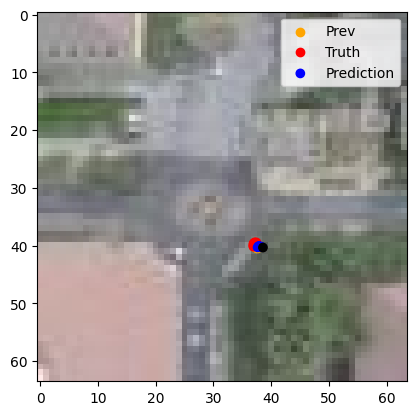

Test Batch 33
0.000251535268034786
5.417221473180689e-05
8


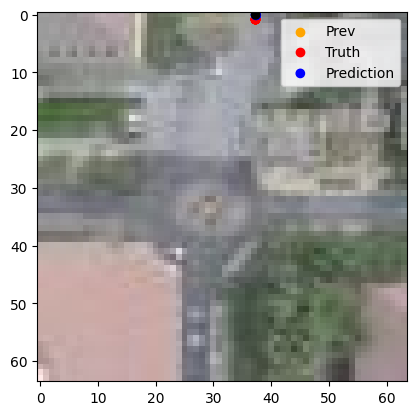

Test Batch 34
0.00035241348086856306
0.0033412149641662836
8


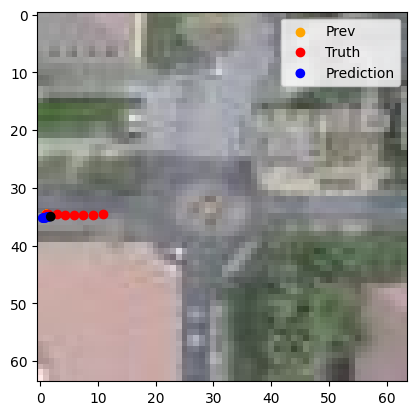

Test Batch 35
9.401164425071329e-05
0.0001984138652915135
8


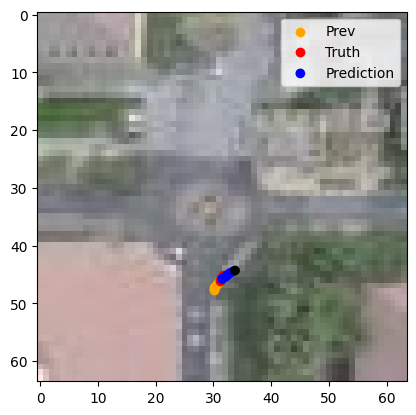

Test Batch 36
0.00019557206542231143
0.0004075474862474948
8


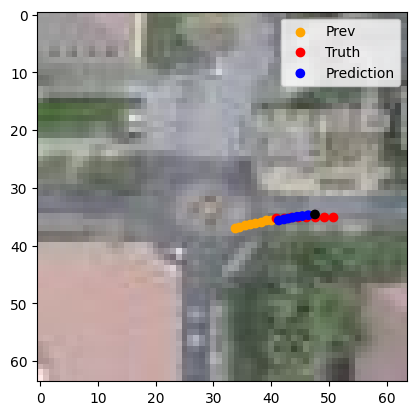

Test Batch 37
0.000557545805349946
0.00019402816542424262
8


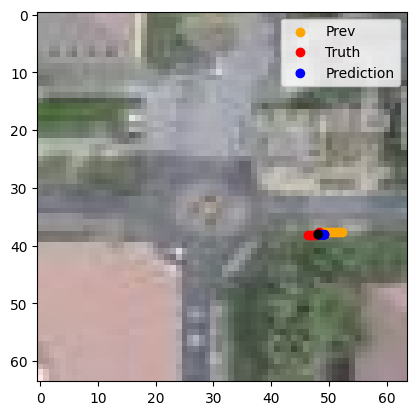

Test Batch 38
0.00027146487263962626
0.0018744278931990266
8


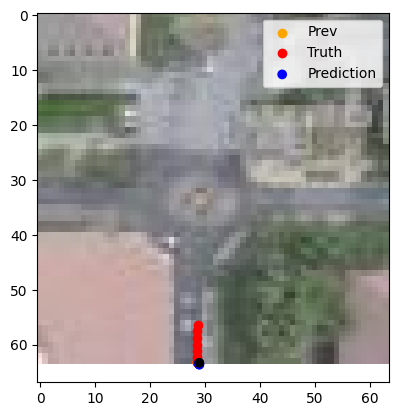

Test Batch 39
0.0006445462349802256
1.617390262254048e-05
8


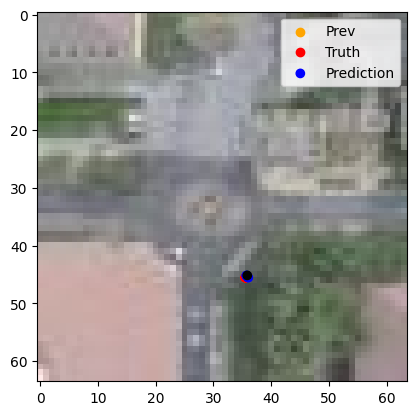

Test Batch 40
0.00010904303780989721
5.833203249494545e-05
8


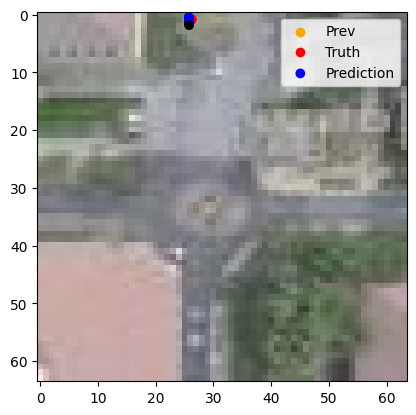

Test Batch 41
0.00020146227325312793
5.401295857154764e-05
8


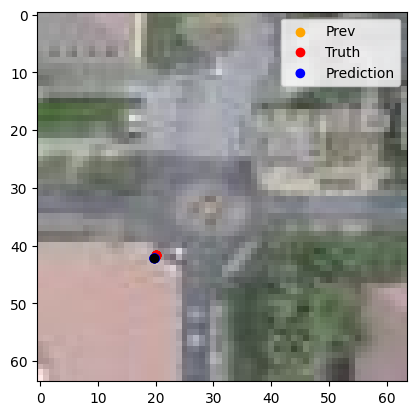

Test Batch 42
0.00018561651813797653
0.00032110593747347593
8


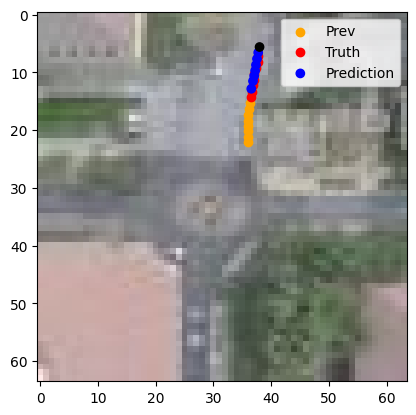

Test Batch 43
0.00025799113791435957
0.0001619666290935129
8


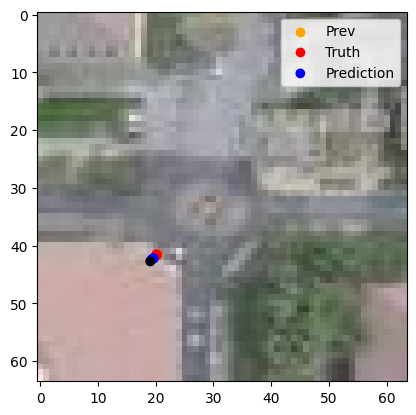

Test Batch 44
0.00025769832427613437
5.2621777285821736e-05
8


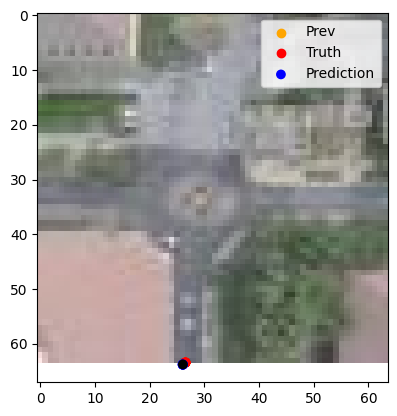

Test Batch 45
0.0002670785179361701
0.0002200104354415089
8


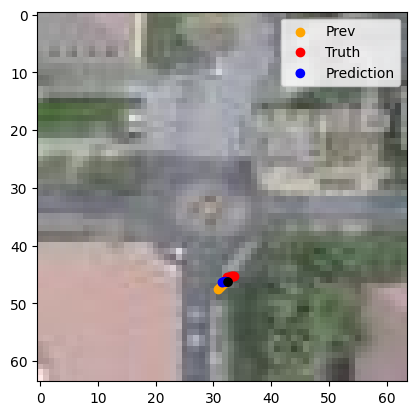

Test Batch 46
0.00011226369679206982
2.5134206225629896e-05
8


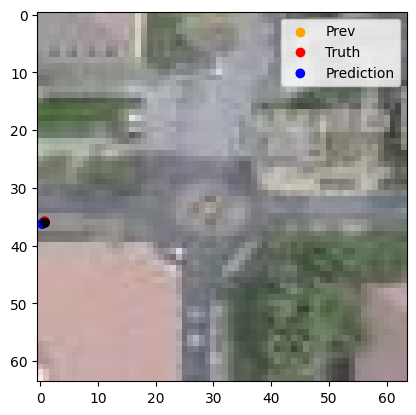

Test Batch 47
0.0002666539803612977
0.0002733975707087666
8


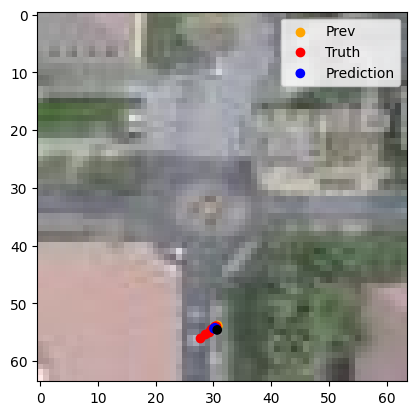

Test Batch 48
0.00014328125689644367
6.8908222601749e-05
8


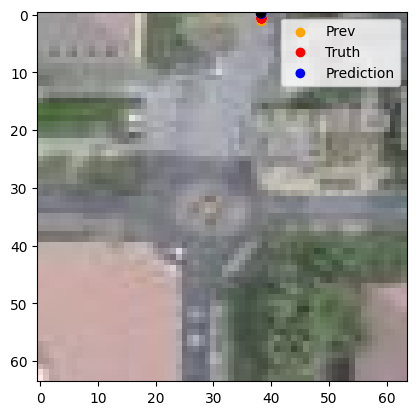

Test Batch 49
0.00014427813584916294
1.3445631338981912e-05
8


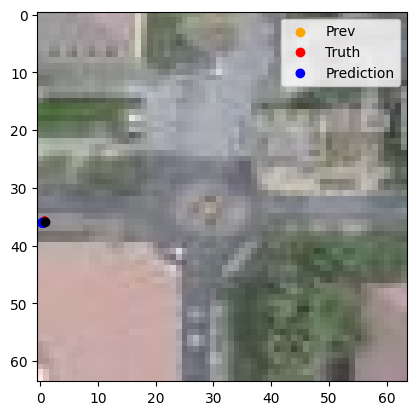

Test Batch 50
0.00015142298070713878
9.096062422031537e-05
8


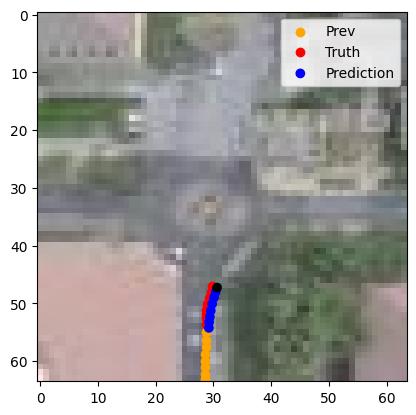

Test Batch 51
9.901334124151617e-05
3.507937435642816e-05
8


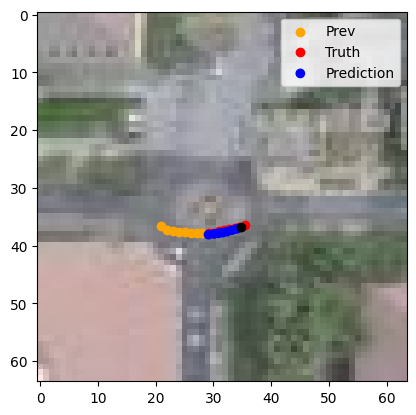

Test Batch 52
0.00044252758380025625
0.0002784340758807957
8


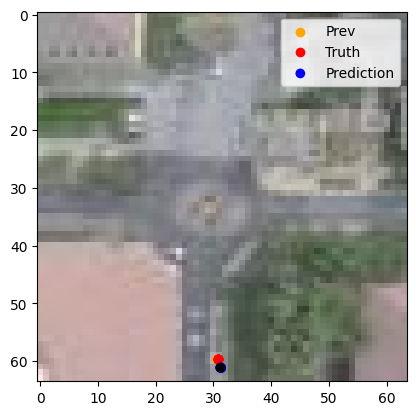

Test Batch 53
0.00015221329522319138
0.0004443204088602215
8


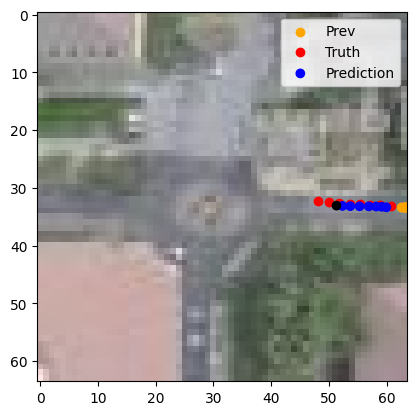

Test Batch 54
0.00020970479818060994
6.792366912122816e-05
8


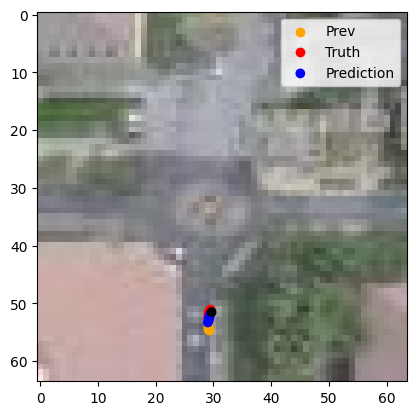

Test Batch 55
0.0002489400503691286
7.443023787345737e-05
8


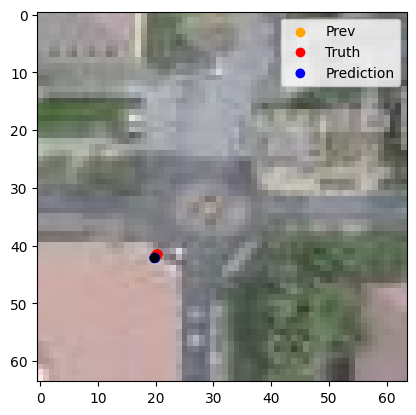

Test Batch 56
0.0004473006119951606
0.00018333208572585136
8


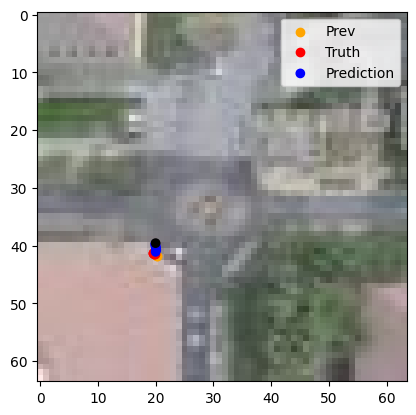

Test Batch 57
0.00026262764004059136
0.00022569712018594146
8


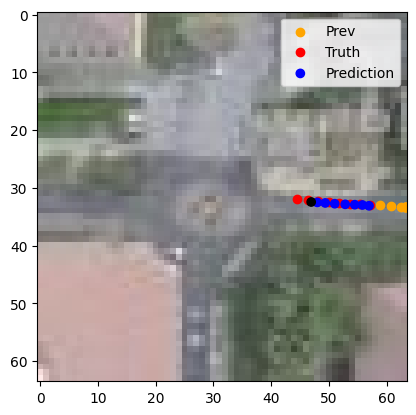

Test Batch 58
0.00023840127687435597
0.0001691211073193699
8


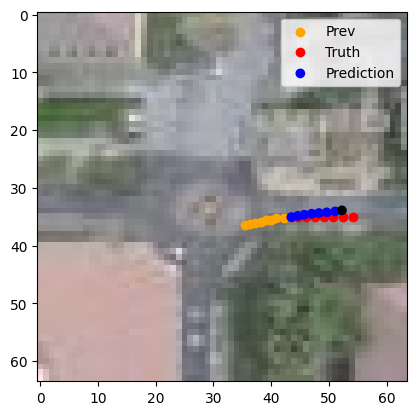

Test Batch 59
0.00040832508238963783
7.183068373706192e-05
8


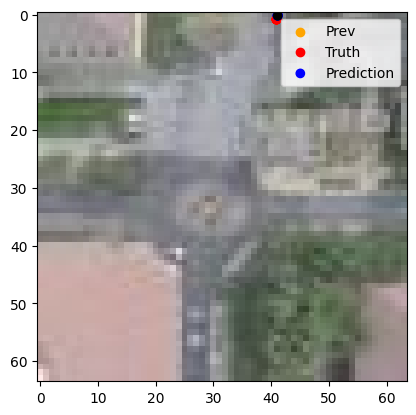

Test Batch 60
0.00015228457050397992
3.798684338107705e-05
8


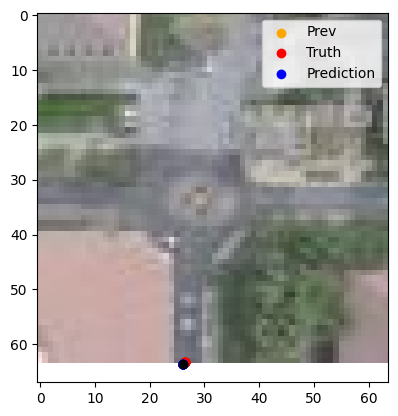

Test Batch 61
9.407381003256887e-05
2.160661097150296e-05
8


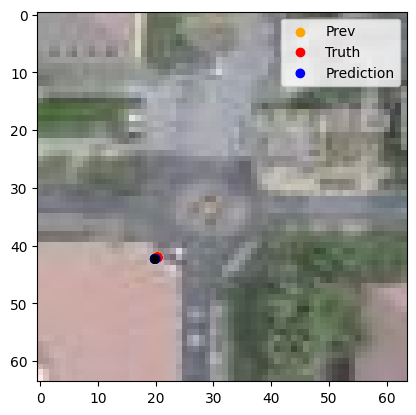

Test Batch 62
0.0002962250146083534
4.291520599508658e-05
8


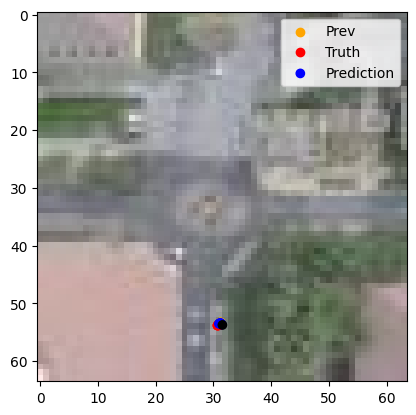

Test Batch 63
0.0001891945139504969
0.00032786509837023914
8


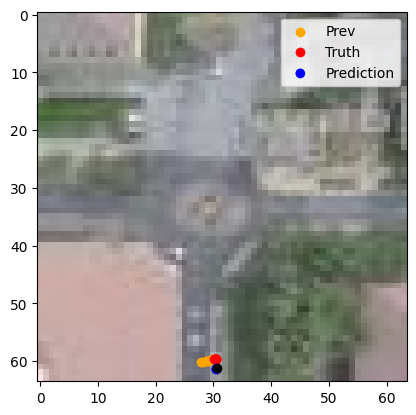

Test Batch 64
0.00020576915994752198
0.0003154419537167996
8


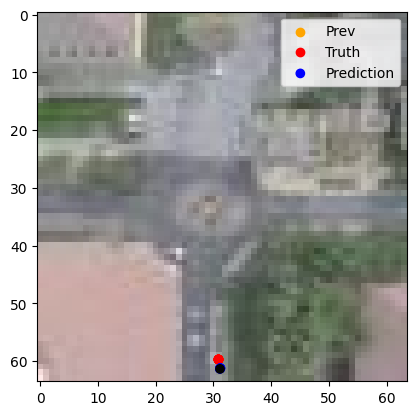

Test Batch 65
0.00011628914944594726
8.883071132004261e-06
8


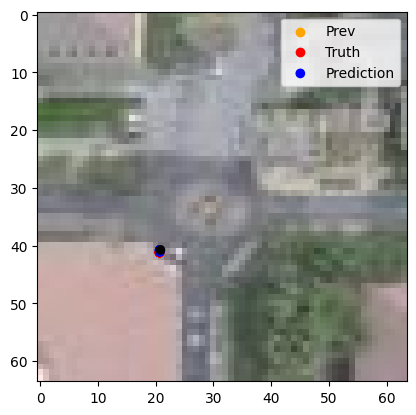

Test Batch 66
0.00011117925896542147
0.00033135610283352435
8


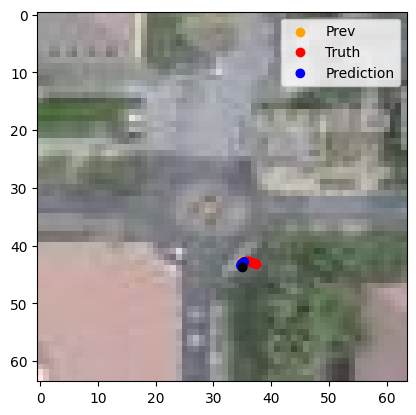

Test Batch 67
0.00024136126739904284
6.7336472966417205e-06
8


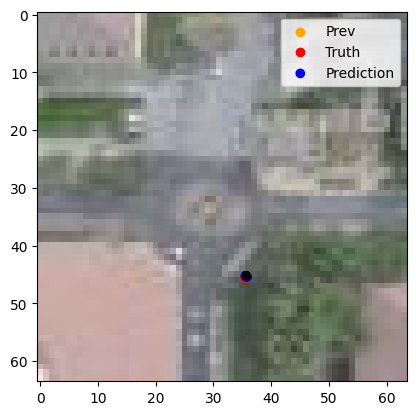

Test Batch 68
0.00020366854732856154
0.00014089859905652702
8


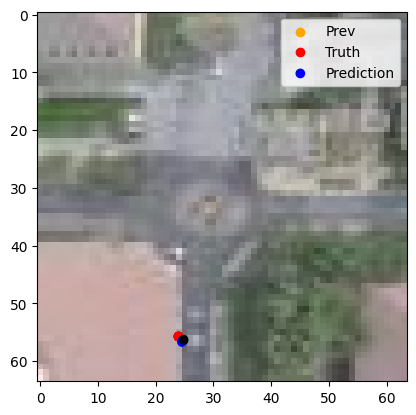

Test Batch 69
0.0004248762270435691
1.9076165699516423e-05
8


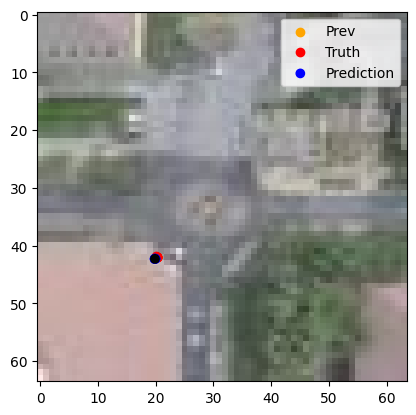

Test Batch 70
0.0003810965863522142
1.638914181967266e-05
8


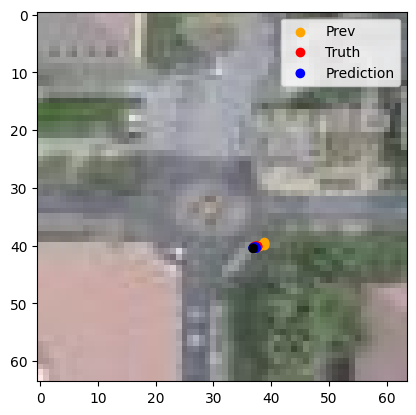

Test Batch 71
0.00013537394988816231
0.0001406208612024784
8


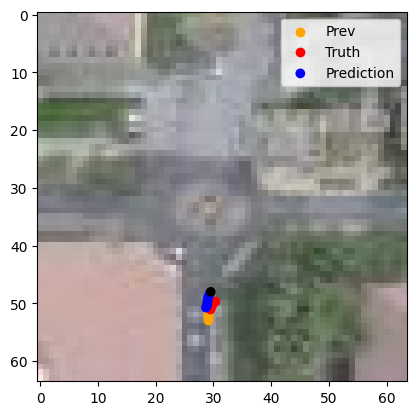

Test Batch 72
0.00020448857685551047
0.00016837248404044658
8


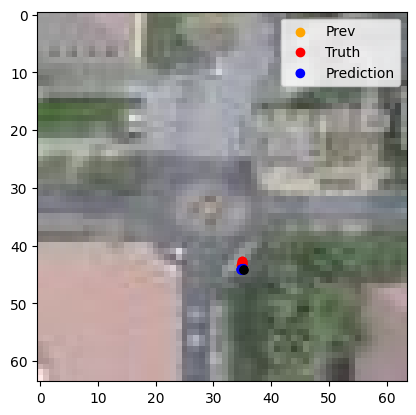

Test Batch 73
0.0003062861505895853
0.0005692163831554353
8


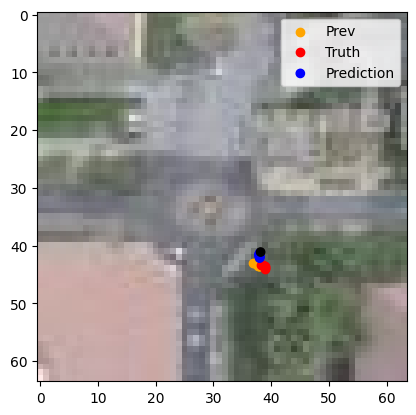

Test Batch 74
0.0003049011284019798
0.00011339280172251165
8


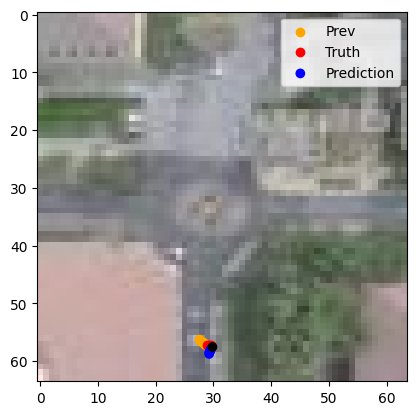

Test Batch 75
0.0002612253010738641
0.00016408572264481336
8


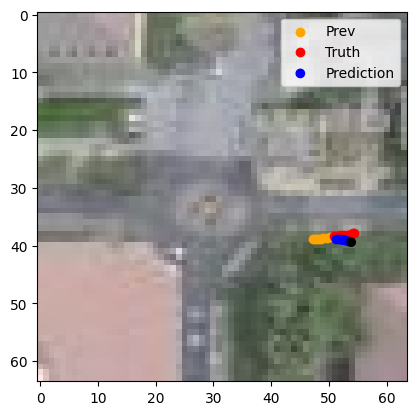

Test Batch 76
9.220492211170495e-05
7.753509999020025e-05
8


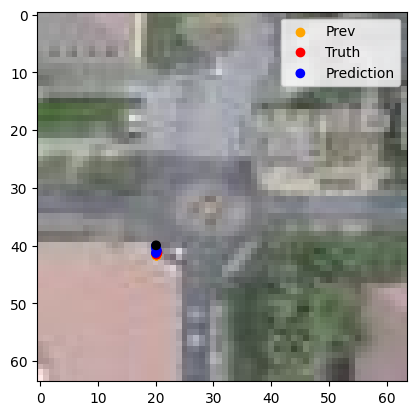

Test Batch 77
0.00018009560881182551
1.4770312191103585e-05
8


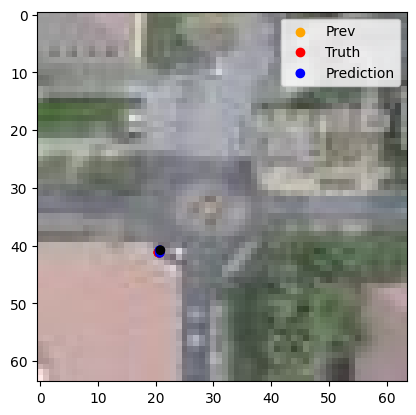

Test Batch 78
0.0001431570271961391
2.5583671231288463e-05
8


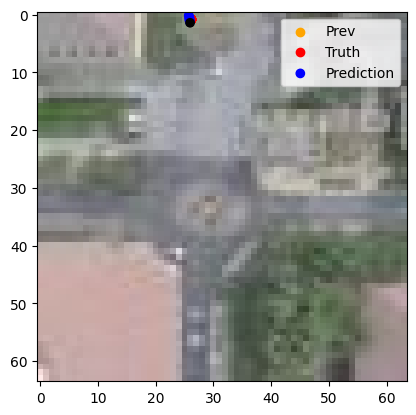

Test Batch 79
0.00015132108819670975
0.00011062248813686892
8


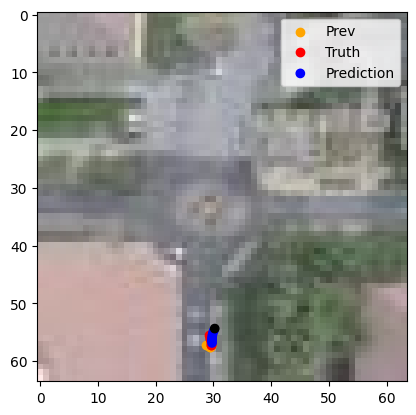

Test Batch 80
0.00013600659440271556
0.00011619464203249663
8


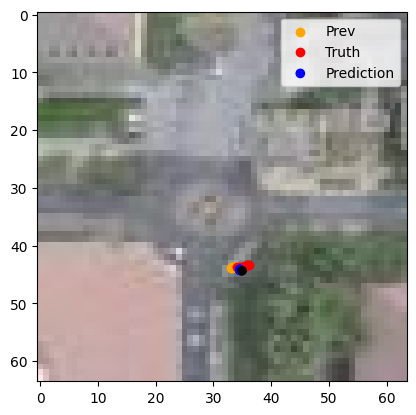

Test Batch 81
0.00021739328803960234
0.0002246744988951832
8


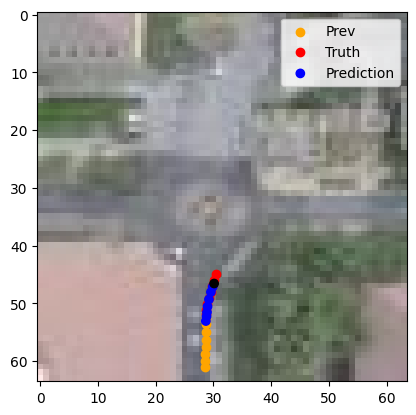

Test Batch 82
0.0001845654915086925
0.00017083047714550048
8


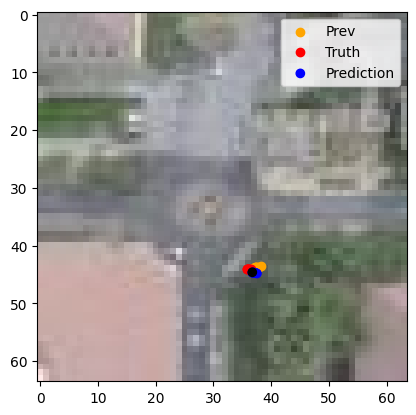

Test Batch 83
0.0005631849635392427
0.00017464531993027776
8


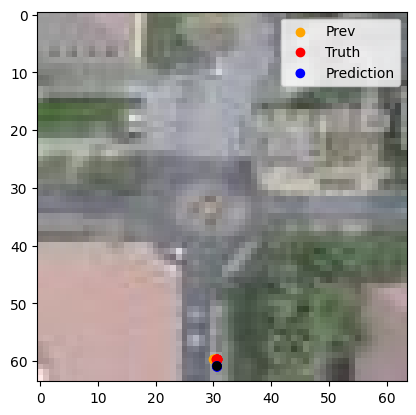

Test Batch 84
0.00011172686208738014
3.147133975289762e-05
8


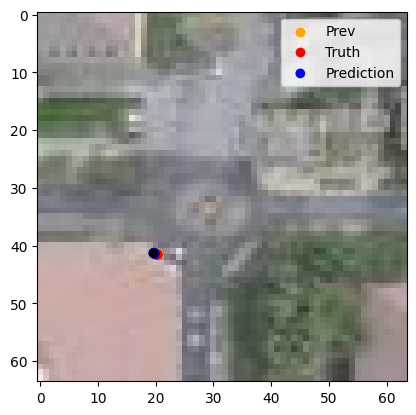

Test Batch 85
0.00021612395357806236
0.00017391046276316047
8


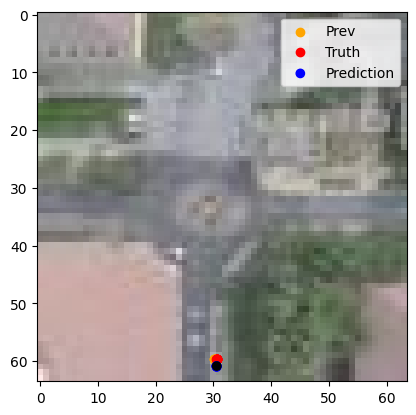

Test Batch 86
0.00032629191991873085
0.0004156896029599011
8


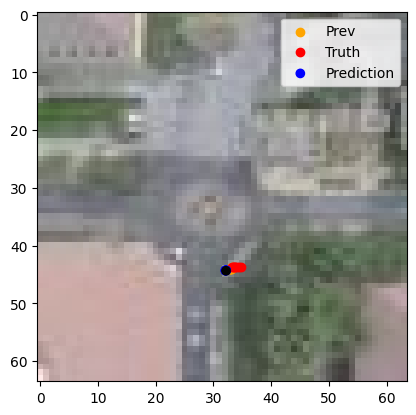

Test Batch 87
0.0002910637704189867
0.00033005079603753984
8


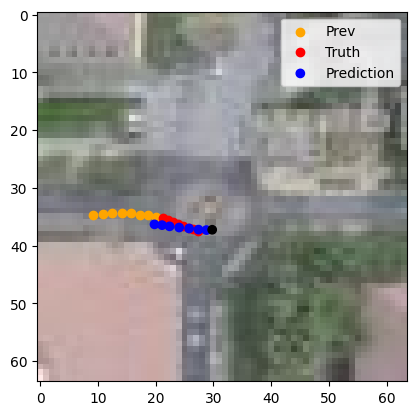

Test Batch 88
0.0005080571281723678
7.695029489696026e-05
8


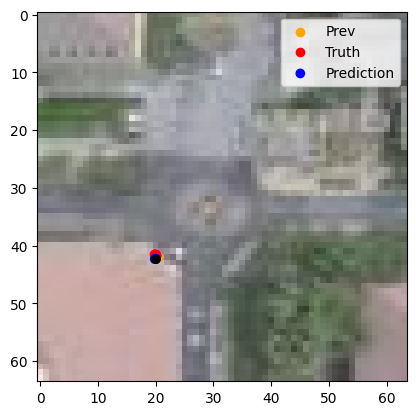

Test Batch 89
0.00019325700122863054
6.817514804424718e-05
8


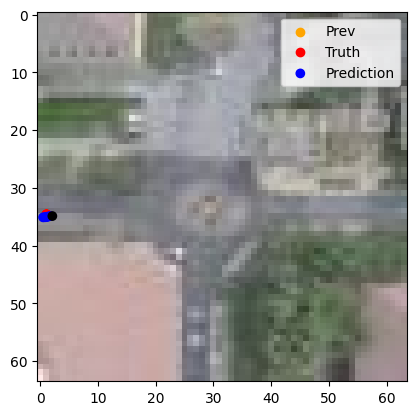

Test Batch 90
0.0005917677190154791
8.124165469780564e-05
8


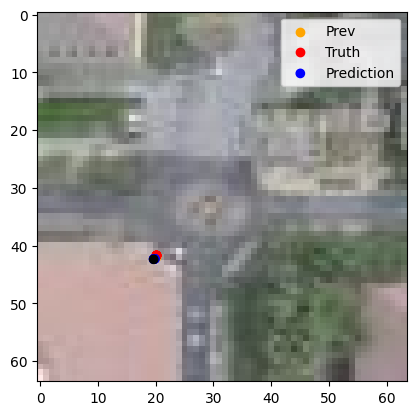

Test Batch 91
6.794281944166869e-05
1.5656794857932255e-05
8


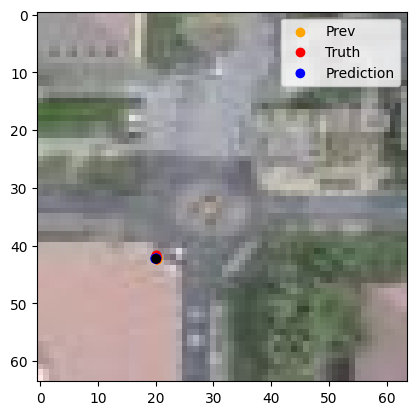

In [13]:
criterion = torch.nn.MSELoss()
k = 0

counter += 1
print(counter)

torch.manual_seed(counter)

for id_b2, batch_test in enumerate(val_loader):
    counter += 1
    with torch.no_grad():
        print(f"Test Batch {id_b2}")
        model.eval()

        X_test = batch_test["src"]
        Y_test = batch_test["tgt"]


        X_coords = batch_test["coords"]
        
        path = batch_test["path"]

        future = None

        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output

        print(criterion(pred,Y_test.to(device)).item())
        print(criterion(pred[0],Y_test[0].to(device)).item())
        prev = [(k[0]*64,k[1]*64) for k in X_coords[0]]
        points = [(k[0]*64,k[1]*64) for k in Y_test[0]]
        points2 = [(k[0]*64,k[1]*64) for k in pred[0].cpu().detach().numpy()]

        prev_x,prev_y = zip(*prev)
        x,y = zip(*points)
        x2,y2 = zip(*points2)
        print(len(points))
        img = PIL.Image.open(path[0]+"/reference.jpg")
        plt.imshow(img)
        plt.scatter([k for k in prev_x],[k for k in prev_y], label="Prev",color="orange")
        plt.scatter([k for k in x],[k for k in y], label="Truth",color="red")
        plt.scatter([k for k in x2],[k for k in y2],label="Prediction",color=(["blue" for k in range(7)] + ["black"]))
        plt.legend()
        #plt.xlim(0,64)
        #plt.ylim(0,64)
        

        plt.savefig("/waldo/walban/student_datasets/arfranck/SDD/plots/val_dim_128.pdf")
        plt.show()




In [47]:
### Test for error with number of predictions
criterion = torch.nn.MSELoss()
stats = {k:[] for k in range(8)}
for id_b2, batch_test in enumerate(val_loader):
    

    with torch.no_grad():
        print(f"Test Batch {id_b2}")
        model.eval()

        X_test = batch_test["src"]
        Y_test = batch_test["tgt"]


        X_coords = batch_test["coords"]

        print(X_coords.shape)
        future = None

        for k in range(8):
            
            pred,output = model(X_test.to(device),future,train=False)
    
            stats[k].append(criterion(pred[:,k,:],Y_test[:,k,:].to(device)).item())
            future = output

        print(criterion(pred,Y_test.to(device)).item())
        print(criterion(pred[0],Y_test[0].to(device)).item())
        prev = [(k[0]*64,k[1]*64) for k in X_coords[0]]
        points = [(k[0]*64,k[1]*64) for k in Y_test[0]]
        points2 = [(k[0]*64,k[1]*64) for k in pred[0].cpu().detach().numpy()]

        prev_x,prev_y = zip(*prev)
        x,y = zip(*points)
        x2,y2 = zip(*points2)
        print(len(points))


Test Batch 0
torch.Size([16, 8, 2])
0.0030807899311184883
0.0006158880423754454
8
Test Batch 1
torch.Size([16, 8, 2])
0.0028705375734716654
0.014689560048282146
8
Test Batch 2
torch.Size([16, 8, 2])
0.0014249957166612148
0.0020224456675350666
8
Test Batch 3
torch.Size([16, 8, 2])
0.003565722843632102
0.001027110032737255
8
Test Batch 4
torch.Size([16, 8, 2])
0.003784001572057605
0.002424955368041992
8
Test Batch 5
torch.Size([16, 8, 2])
0.003554545110091567
0.023558514192700386
8
Test Batch 6
torch.Size([16, 8, 2])
0.0025181546807289124
0.00021263948292471468
8
Test Batch 7
torch.Size([16, 8, 2])
0.004124779719859362
0.002092248061671853
8
Test Batch 8
torch.Size([16, 8, 2])
0.002649822738021612
0.004004903603345156
8
Test Batch 9
torch.Size([16, 8, 2])
0.0016813157126307487
0.006000500172376633
8
Test Batch 10
torch.Size([16, 8, 2])
0.003336478490382433
0.0007803468033671379
8
Test Batch 11
torch.Size([16, 8, 2])
0.0014279319439083338
0.006472748704254627
8
Test Batch 12
torch.Size([1

[0.0007600193335251374, 0.0009620284426174211, 0.0013998324575368315, 0.00210529738582078, 0.0030172261480898173, 0.004318281926151196, 0.00590494146507064, 0.007144214119762182]
{0: [0.0008536311215721071, 0.0007960931397974491, 0.0006884169997647405, 0.00224087992683053, 0.0012778526870533824, 0.0005922592245042324, 0.0007008592365309596, 0.0006397113902494311, 0.0008327188552357256, 0.0006716072675772011, 0.0005740463966503739, 0.0003706817515194416, 0.0008221456664614379, 0.0012404621811583638, 0.0005921585252508521, 0.0008401138475164771, 0.0007630412001162767, 0.0009105763165280223, 0.0007131234742701054, 0.0004896490718238056, 0.0005862412508577108, 0.0008263922645710409, 0.00040477473521605134, 0.0008888838347047567, 0.0005724799120798707, 0.0010202170815318823, 0.0008516947273164988, 0.0007371857645921409, 0.0006158413598313928, 0.0006325056892819703, 0.0006825199816375971, 0.0007363127078860998, 0.0006453116075135767, 0.0007072503212839365, 0.0009504478657618165, 0.0004488813

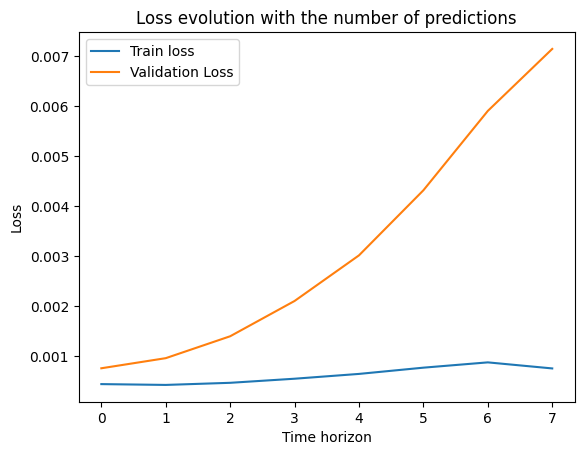

In [49]:

import numpy as np
x = [np.mean(k) for k in stats.values()]
print(x)
print(stats)
plt.xlabel("Time horizon")
plt.ylabel("Loss")
plt.title("Loss evolution with the number of predictions")
plt.plot(train_loss,label="Train loss")
plt.plot(x,label="Validation Loss")
plt.legend()
plt.show()